# This notebook must be run with the Vizgen_2 conda environment within the Vizgen.sif singularity container

In [1]:
import scanpy as sc
import pandas as pd
import os
import string
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import Mapping
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial

import skimage
import cv2
from skimage.morphology import disk, opening, closing
from scipy.ndimage import binary_fill_holes, label, distance_transform_edt
from skimage.segmentation import find_boundaries, watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.segmentation import watershed
import anndata
from adjustText import adjust_text

import Mapping
import os
import string

import cv2
import geopandas as gpd
import igraph as ig
#import leidenalg
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import tifffile
import umap
from anndata import AnnData as ad
from matplotlib import patches as mpatches
#from matplotlib_scalebar.scalebar import ScaleBar
import scanpy as sc
import anndata
from shapely.affinity import translate
from shapely.geometry import Polygon, MultiPolygon, box, shape
from skimage import img_as_bool, img_as_ubyte
from skimage.measure import find_contours, regionprops, regionprops_table
from skimage.morphology import skeletonize, opening
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from skimage.segmentation import find_boundaries
from tqdm import tqdm
import matplotlib.patches as patches

from matplotlib_venn import venn2
import gseapy as gp
import seaborn as sns
import scipy.stats as stats
import pandas as pd
from statsmodels.stats.multitest import multipletests

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-13 12:49:29.404836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 12:49:29.422909: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 12:49:29.428403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 12:49:29.442349: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFl

In [2]:
def plot_random_cells_from_cluster(data, cluster_id,column='leiden', num_cells=9,raw=False,random_state=35, conversion_rate=1.0, micron_length=50, output_pdf=None):
    """
    Plot random cells from the specified Leiden cluster.
    
    Args:
    - data (pd.DataFrame): DataFrame containing 'batchID', 'cell_label', and 'leiden_cluster'.
    - cluster_id (int): The Leiden cluster ID to visualize.
    - num_cells (int): Number of cells to display, default is 4.
    """
    # Filter data for the specified cluster
    cluster_data = data[data[column] == cluster_id]
    #print(cluster_data)
    
    # Randomly select cells if there are more than num_cells
    if len(cluster_data) > num_cells:
        cluster_data = cluster_data.sample(n=num_cells, random_state=random_state)
    
    # Create a grid plot
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    axes = axes.flatten()
    
    for ax, (_, row) in zip(axes, cluster_data.iterrows()):
        print(row['batchID'])
        image = load_label_image(row['batchID'], row['x'], row['y'], raw)
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Batch: {row['batchID']}, x: {row['x']}, y:{row['y']}")
        add_scale_bar(ax, conversion_rate, micron_length, location=(10, image.shape[0] - 20))
    
    plt.tight_layout()
    
    if output_pdf:
        plt.savefig(output_pdf, format='pdf', bbox_inches='tight')
    plt.show()

def extract_sub_image_with_padding(image, bbox, padding=10):
    min_row, min_col, max_row, max_col = bbox
    min_row = max(min_row - padding, 0)
    min_col = max(min_col - padding, 0)
    max_row = min(max_row + padding, image.shape[0])
    max_col = min(max_col + padding, image.shape[1])
    return image[min_row:max_row, min_col:max_col], (min_row, min_col)

def add_scale_bar(ax, conversion_rate, micron_length, color='red', location=(10, 10), thickness=50, fontsize=12):
    """
    Add a scale bar to the given axis.

    Args:
    - ax: The axis on which to draw the scale bar.
    - conversion_rate: The pixel-to-micron conversion factor (pixels per micron).
    - micron_length: The length of the scale bar in microns.
    - color: The color of the scale bar.
    - location: A tuple specifying the (x, y) location of the scale bar.
    - thickness: The thickness of the scale bar in pixels.
    """
    # Calculate the length of the scale bar in pixels
    pixel_length = conversion_rate * micron_length
    
    # Create a rectangle for the scale bar
    scale_bar = patches.Rectangle(location, pixel_length, thickness, linewidth=0, edgecolor=color, facecolor=color)
    
    # Add the scale bar to the plot
    ax.add_patch(scale_bar)
    text_x = location[0] + pixel_length + 10  # Place text to the right of the scale bar
    text_y = location[1] + thickness / 2      # Vertically center the text with the scale bar
    ax.text(text_x, text_y, f'{micron_length} μm', color=color, fontsize=fontsize, va='center')


def load_label_image(batchID, x_ax, y_ax,raw=False):
    root = '/hpc/projects/group.quake/doug/Shapes_Spatial/'
    
    transform_file = f'{root}{batchID}/images/micron_to_mosaic_pixel_transform.csv'
    transform_df = pd.read_table(transform_file, sep=' ', header=None)
    transformation_matrix = transform_df.values
    
    x_ax = round(x_ax * transformation_matrix[0,0] + transformation_matrix[0,2])
    y_ax = round(y_ax * transformation_matrix[1,1] + transformation_matrix[1,2])
    
    print(f'load {batchID}')
    raw_im = Mapping.load_tiff_image(root + batchID + '/binary_image.tif')
    
    box_size = 500
    x_start = x_ax - box_size
    x_end = x_ax + box_size
    y_start = y_ax - box_size
    y_end = y_ax + box_size
    
    # Extract the sub-image, ensuring the indices are within bounds
    sub_image = np.zeros((2*box_size, 2*box_size), dtype=raw_im.dtype)
    
    raw_x_start = max(x_start, 0)
    raw_x_end = min(x_end, raw_im.shape[1])
    raw_y_start = max(y_start, 0)
    raw_y_end = min(y_end, raw_im.shape[0])
    
    sub_x_start = max(0, -x_start)
    sub_x_end = sub_x_start + (raw_x_end - raw_x_start)
    sub_y_start = max(0, -y_start)
    sub_y_end = sub_y_start + (raw_y_end - raw_y_start)
    
    sub_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end] = raw_im[raw_y_start:raw_y_end, raw_x_start:raw_x_end]
    
    if raw==True:
        return sub_image
    
    #sub_test = raw_im[(y_ax-500):(y_ax+500), (x_ax-500):(x_ax+500)]
    #print(sub_test.shape)
    
    #if sub_test.size == 0:
     #   return np.zeros((20,20))
    
    subtract = cv2.fastNlMeansDenoising(sub_image)
    pre = cv2.adaptiveThreshold((255 - subtract), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 75, 2)

    opened = opening(255 - pre, disk(3))
    pre = closing(opened, disk(3))

    filled_image = binary_fill_holes(pre)

    labeled_array, num_features = label(filled_image)
    
    point = (500, 500)

    regions = regionprops(labeled_array)

    largest_component_label = None
    max_area = 0

    for region in regions:
        if region.area > 500:
            # Find the boundary of the component
            boundary = find_boundaries(labeled_array == region.label, mode='outer')
            boundary_coords = np.column_stack(np.where(boundary))

            # Calculate the distance from the point to the boundary
            distances = np.linalg.norm(boundary_coords - np.array(point), axis=1)
            min_dist = np.min(distances)

            if min_dist < 100:
                if region.area > max_area:
                    max_area = region.area
                    largest_component_label = region.label

    if largest_component_label is not None:
        isolated_component = labeled_array == largest_component_label

        label_image = np.zeros_like(labeled_array)
        label_image[isolated_component] = 1
        return label_image
        
    return sub_image

In [3]:
new_ad = sc.read_h5ad('Transciptomic_labels_and_morphology_labels_full.h5ad')

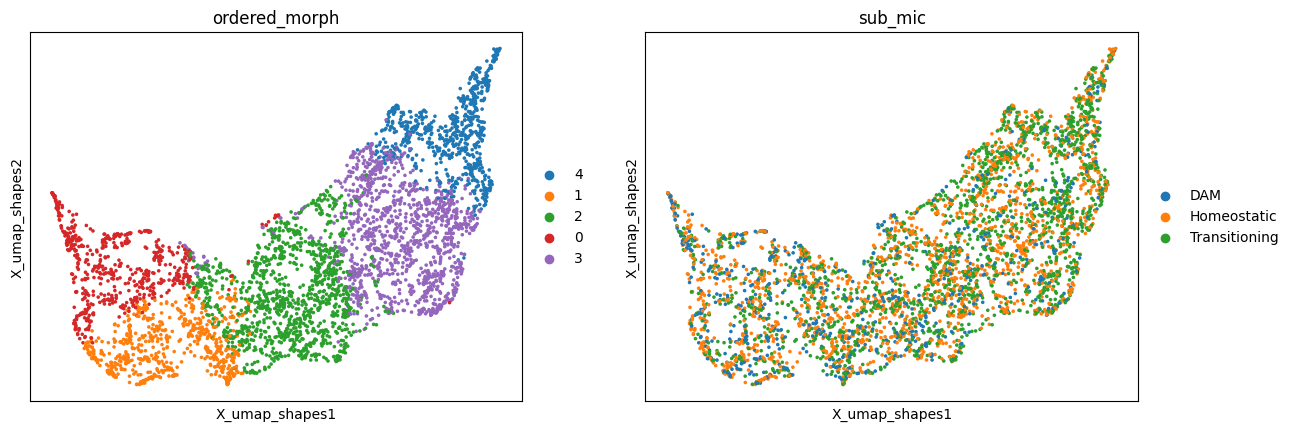

In [4]:
sc.pl.embedding(new_ad, basis = 'X_umap_shapes',color=['ordered_morph','sub_mic'],save='morphology.png')

In [5]:
mosaic_to_micron = pd.read_csv('/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-female-1-rev2/images/micron_to_mosaic_pixel_transform.csv',delimiter=' ').iloc[0,1]

24-mo-male-2
load 24-mo-male-2
24-mo-male-2
load 24-mo-male-2
24-mo-male-2
load 24-mo-male-2
3-mo-female-3
load 3-mo-female-3
24-mo-female-3
load 24-mo-female-3
24-mo-male-2
load 24-mo-male-2
3-mo-female-1-rev2
load 3-mo-female-1-rev2
24-mo-female-5
load 24-mo-female-5
24-mo-female-5
load 24-mo-female-5


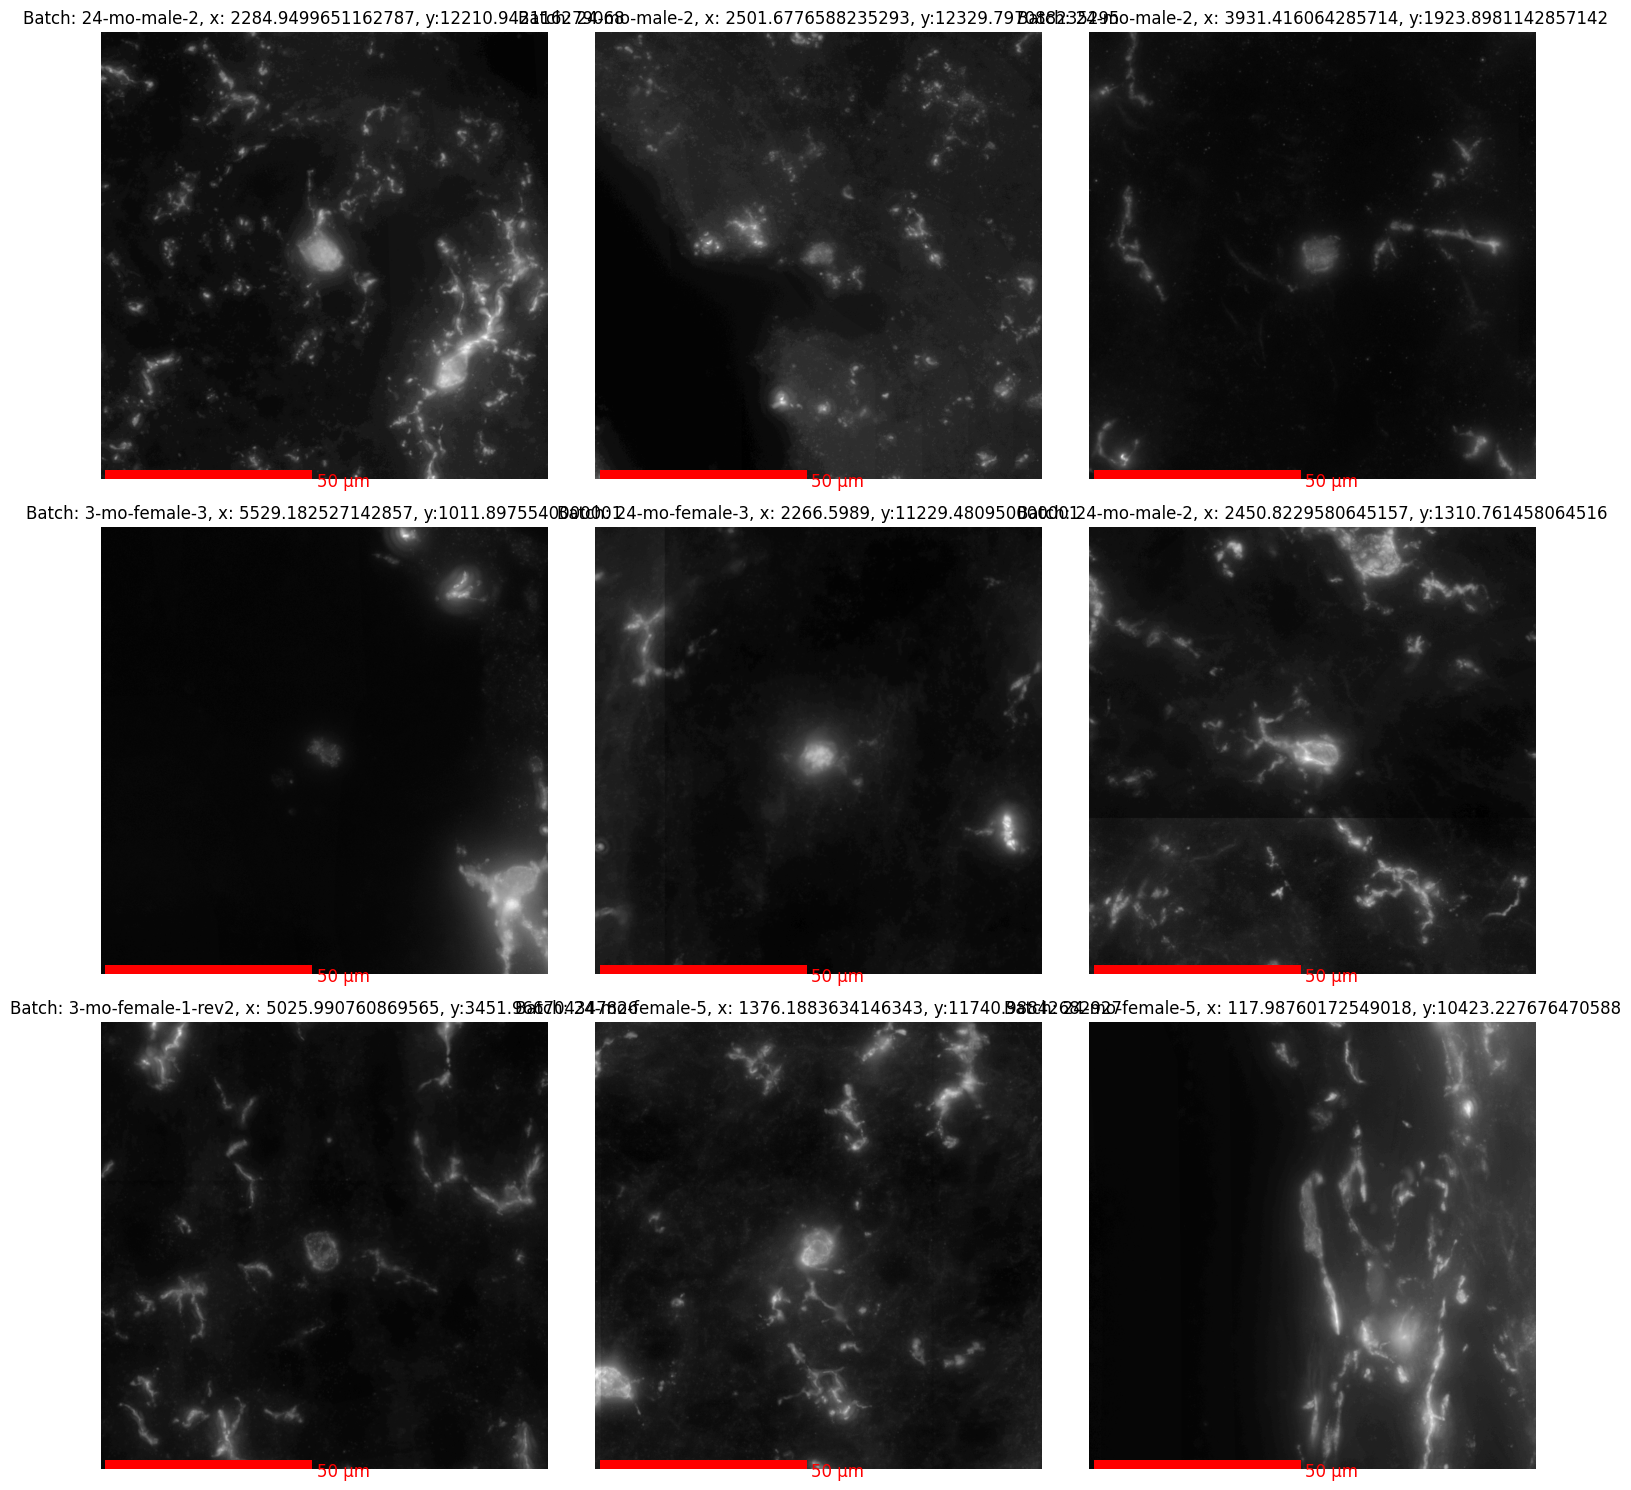

In [6]:
plot_random_cells_from_cluster(new_ad.obs, cluster_id='0', column='ordered_morph', raw=True,conversion_rate=mosaic_to_micron,output_pdf='phagocytic_0_examples.pdf')

3-mo-female-3
load 3-mo-female-3
3-mo-male-1
load 3-mo-male-1
24-mo-male-4-rev2
load 24-mo-male-4-rev2
3-mo-male-2
load 3-mo-male-2
24-mo-female-3
load 24-mo-female-3
24-mo-female-5
load 24-mo-female-5
3-mo-female-2
load 3-mo-female-2
3-mo-male-3-rev2
load 3-mo-male-3-rev2
24-mo-male-2
load 24-mo-male-2


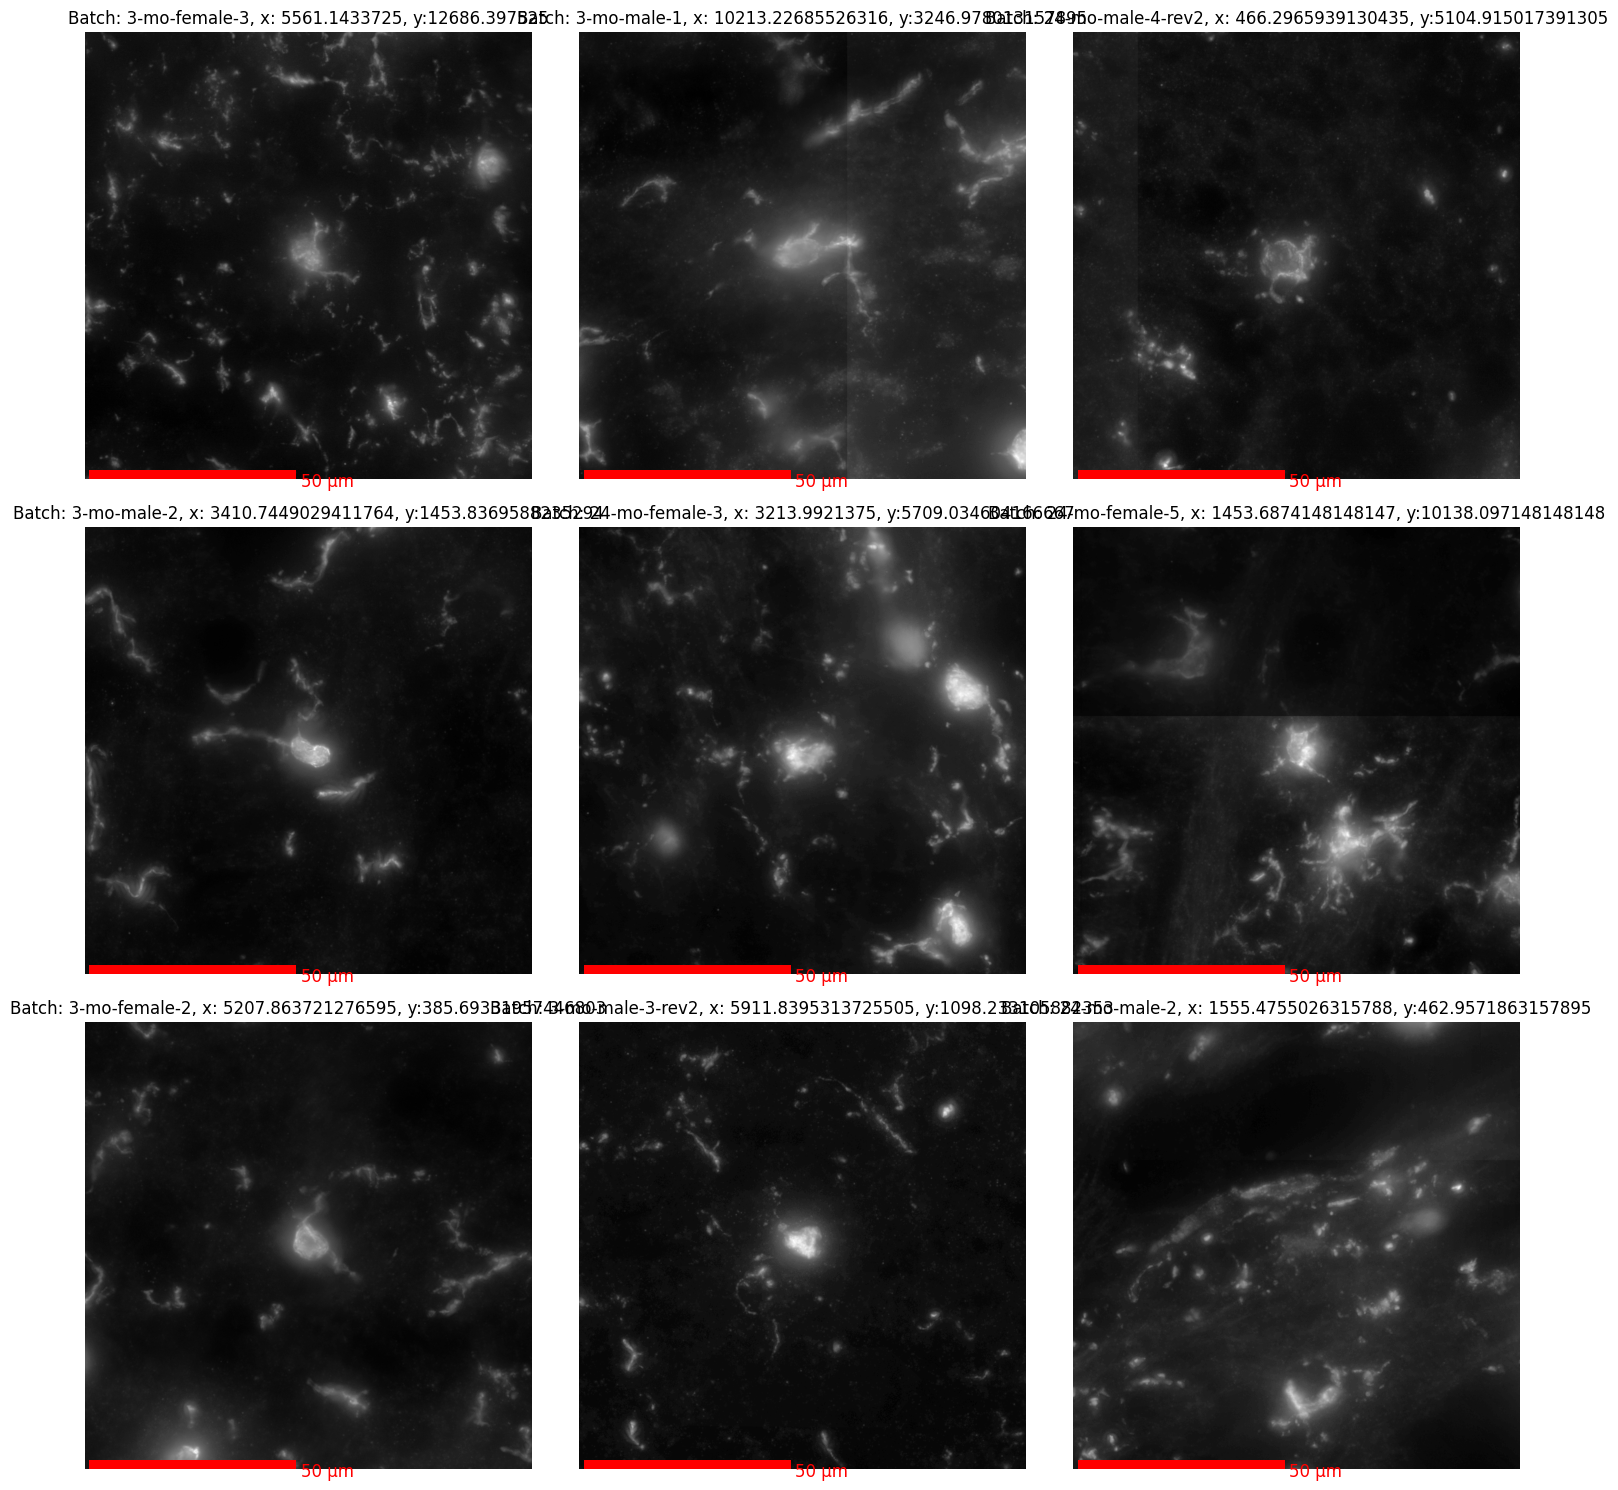

In [7]:
plot_random_cells_from_cluster(new_ad.obs, cluster_id='1', column='ordered_morph', raw=True,conversion_rate=mosaic_to_micron,output_pdf='phagocytic_1_examples.pdf')

24-mo-male-2
load 24-mo-male-2
24-mo-female-5
load 24-mo-female-5
24-mo-male-4-rev2
load 24-mo-male-4-rev2
24-mo-male-2
load 24-mo-male-2
24-mo-female-5
load 24-mo-female-5
24-mo-female-3
load 24-mo-female-3
24-mo-female-5
load 24-mo-female-5
3-mo-female-3
load 3-mo-female-3
24-mo-female-5
load 24-mo-female-5


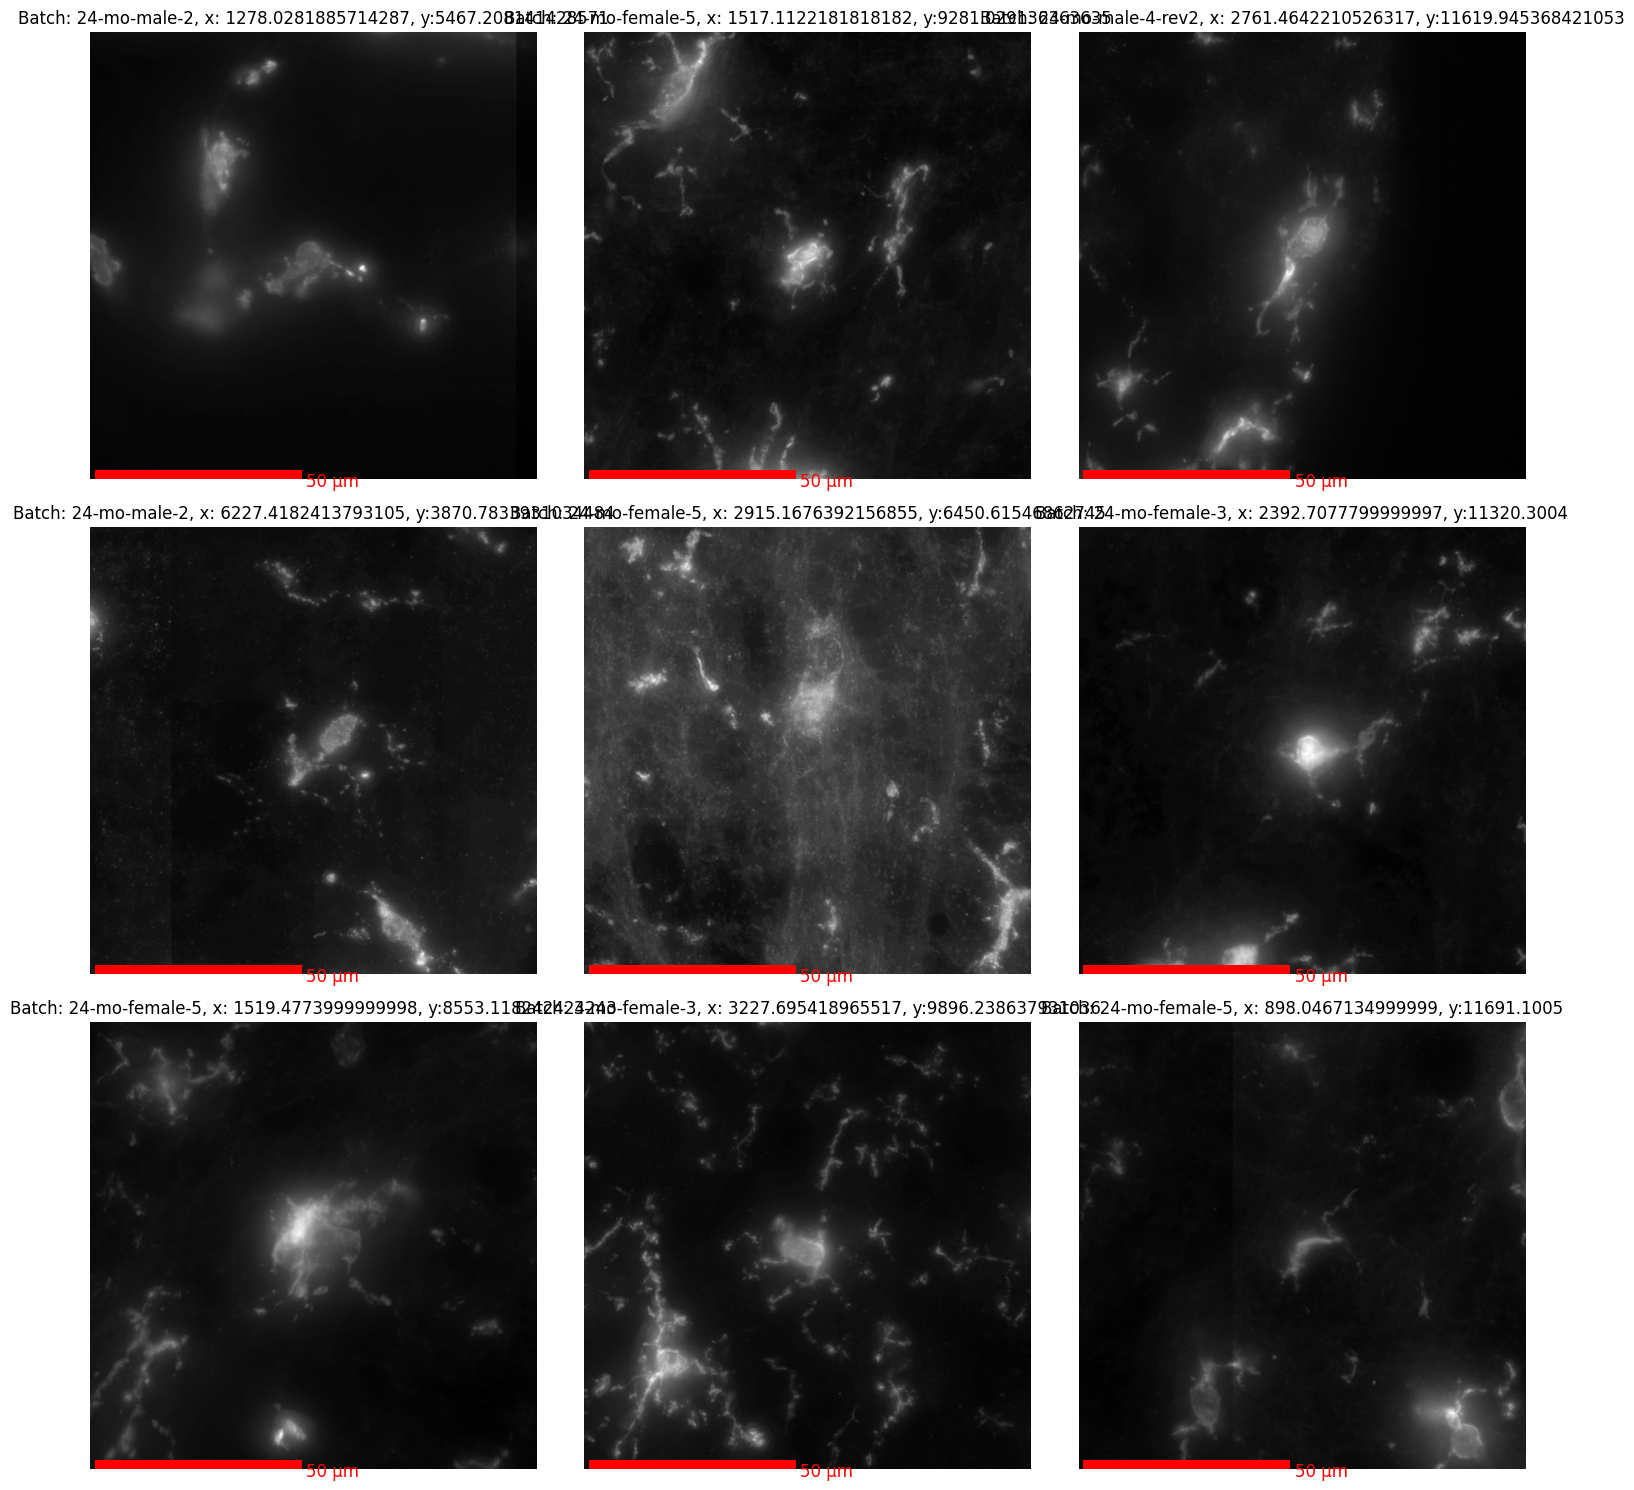

In [8]:
plot_random_cells_from_cluster(new_ad.obs, cluster_id='2', column='ordered_morph', raw=True,conversion_rate=mosaic_to_micron,output_pdf='ramified_2_examples.pdf')

24-mo-female-5
load 24-mo-female-5
3-mo-female-3
load 3-mo-female-3
3-mo-female-2
load 3-mo-female-2
24-mo-male-2
load 24-mo-male-2
3-mo-female-1-rev2
load 3-mo-female-1-rev2
24-mo-female-1
load 24-mo-female-1
3-mo-female-1-rev2
load 3-mo-female-1-rev2
3-mo-female-1-rev2
load 3-mo-female-1-rev2
24-mo-female-5
load 24-mo-female-5


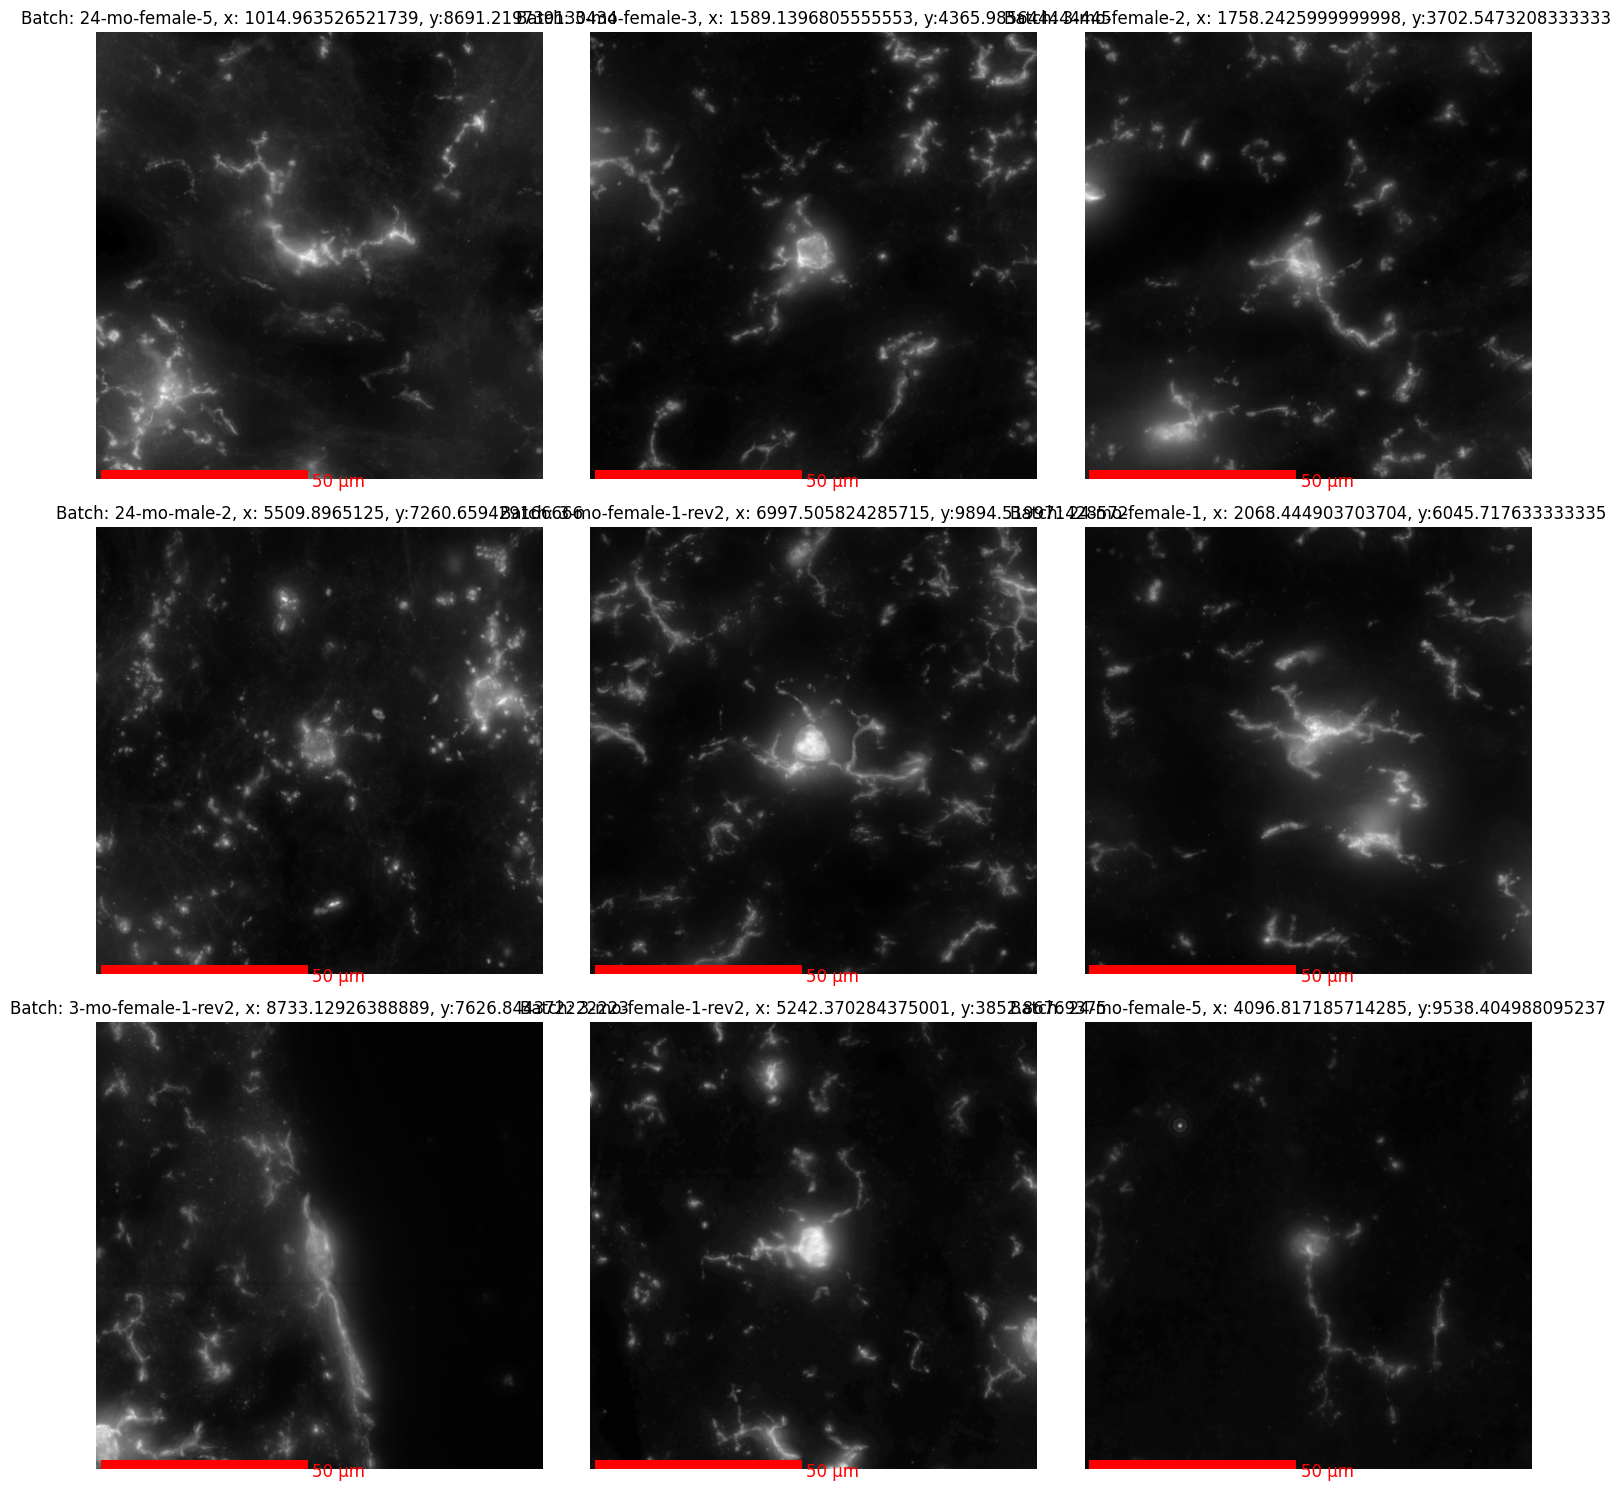

In [9]:
plot_random_cells_from_cluster(new_ad.obs, cluster_id='3', column='ordered_morph', raw=True,conversion_rate=mosaic_to_micron,output_pdf='ramified_3_examples.pdf')

24-mo-female-3
load 24-mo-female-3
3-mo-male-2
load 3-mo-male-2
24-mo-female-5
load 24-mo-female-5
24-mo-male-2
load 24-mo-male-2
24-mo-female-3
load 24-mo-female-3
3-mo-female-3
load 3-mo-female-3
24-mo-female-3
load 24-mo-female-3
3-mo-female-3
load 3-mo-female-3
3-mo-female-3
load 3-mo-female-3


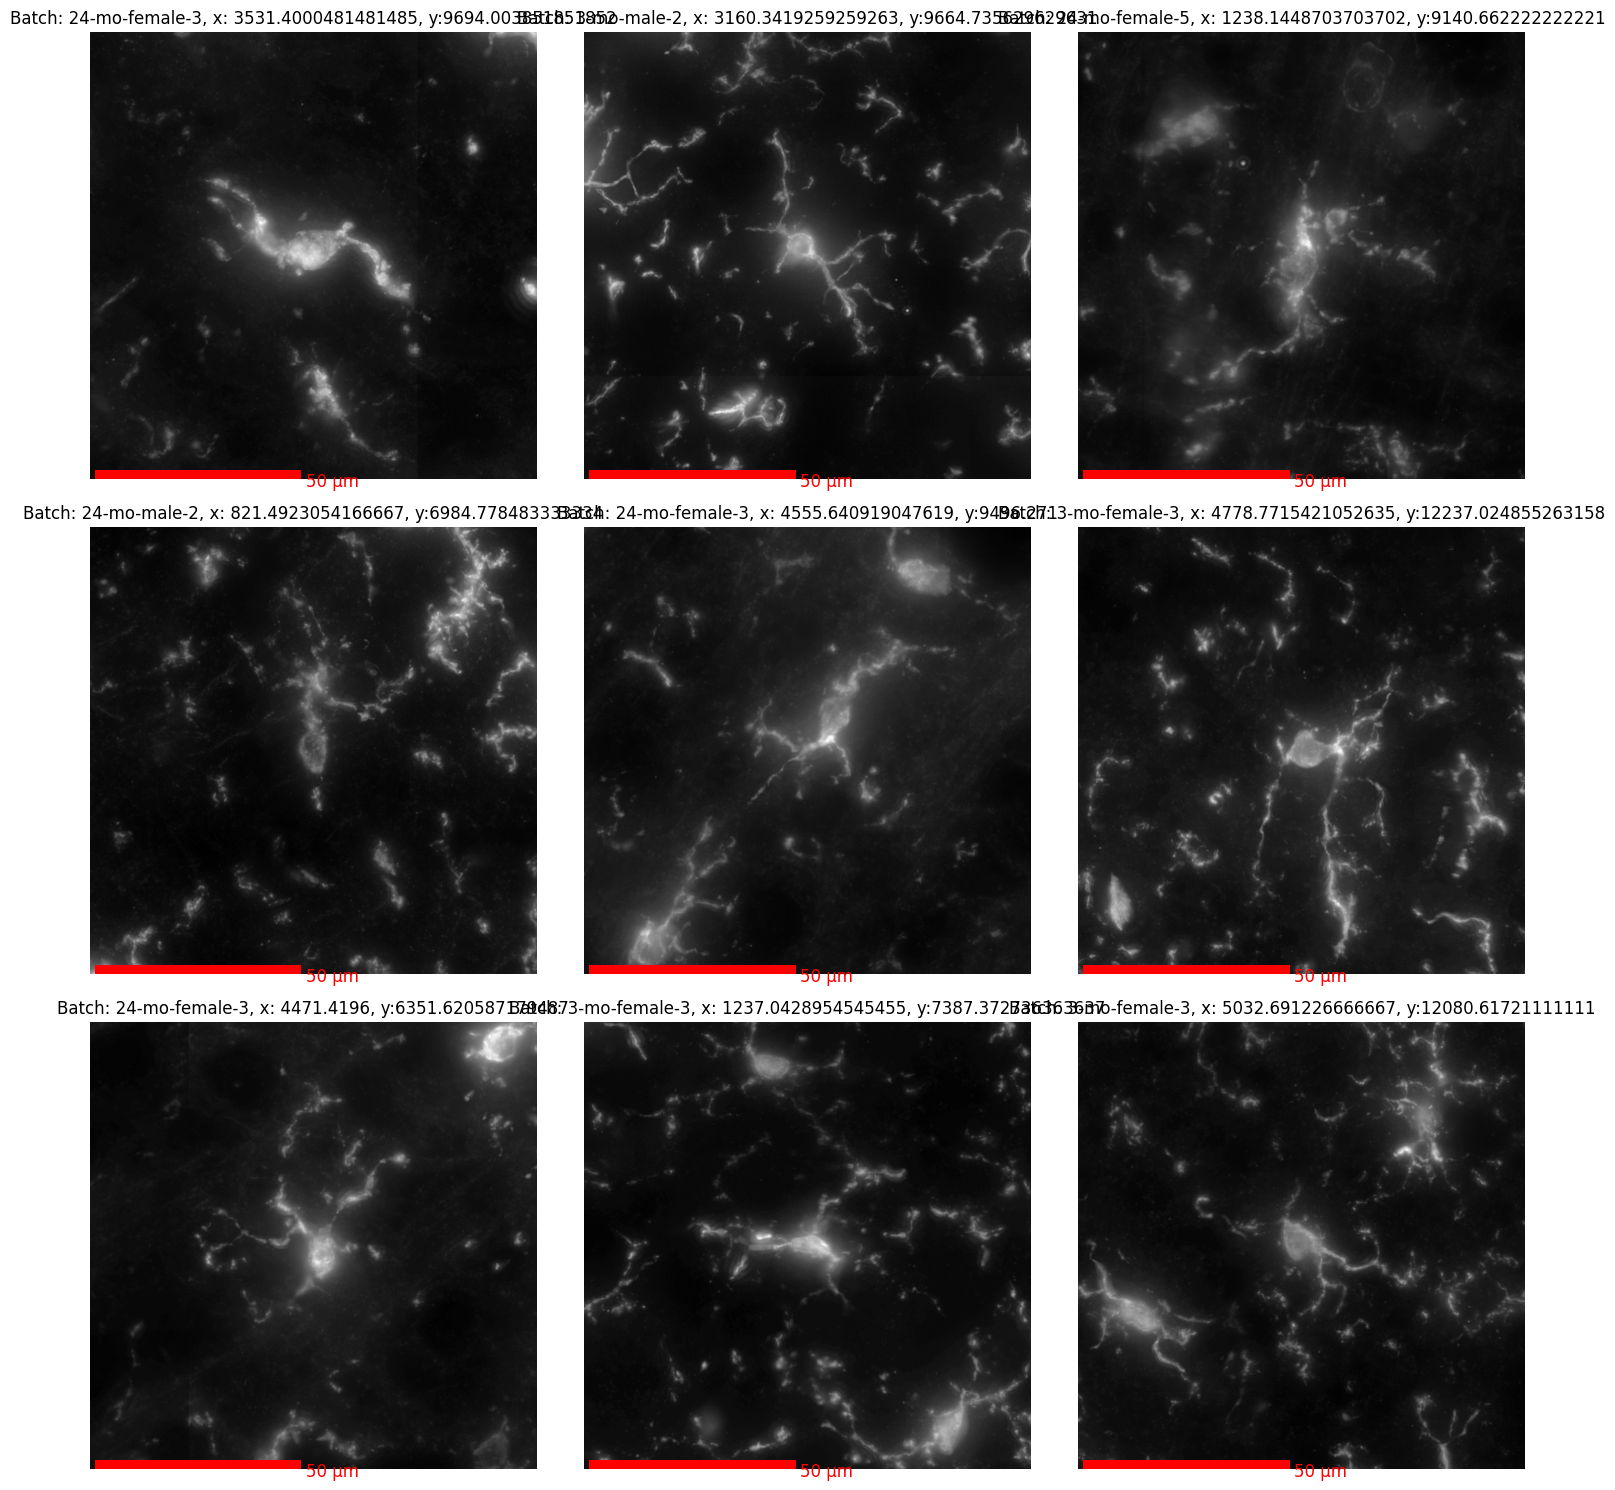

In [10]:
plot_random_cells_from_cluster(new_ad.obs, cluster_id='4', column='ordered_morph', raw=True,conversion_rate=mosaic_to_micron,output_pdf='ramified_4_examples.pdf')

In [11]:
start_index = list(new_ad.obs.columns).index('Cell Area')  # Add 1 to include the column itself
columns_after_specific = new_ad.obs.iloc[:, start_index:].values

morphological_columns = new_ad.obs.columns[start_index:]

features = morphological_columns[:-11].tolist()

features_set = set(features) - set(['Radius of Influence'])
features = [i for i in features_set]

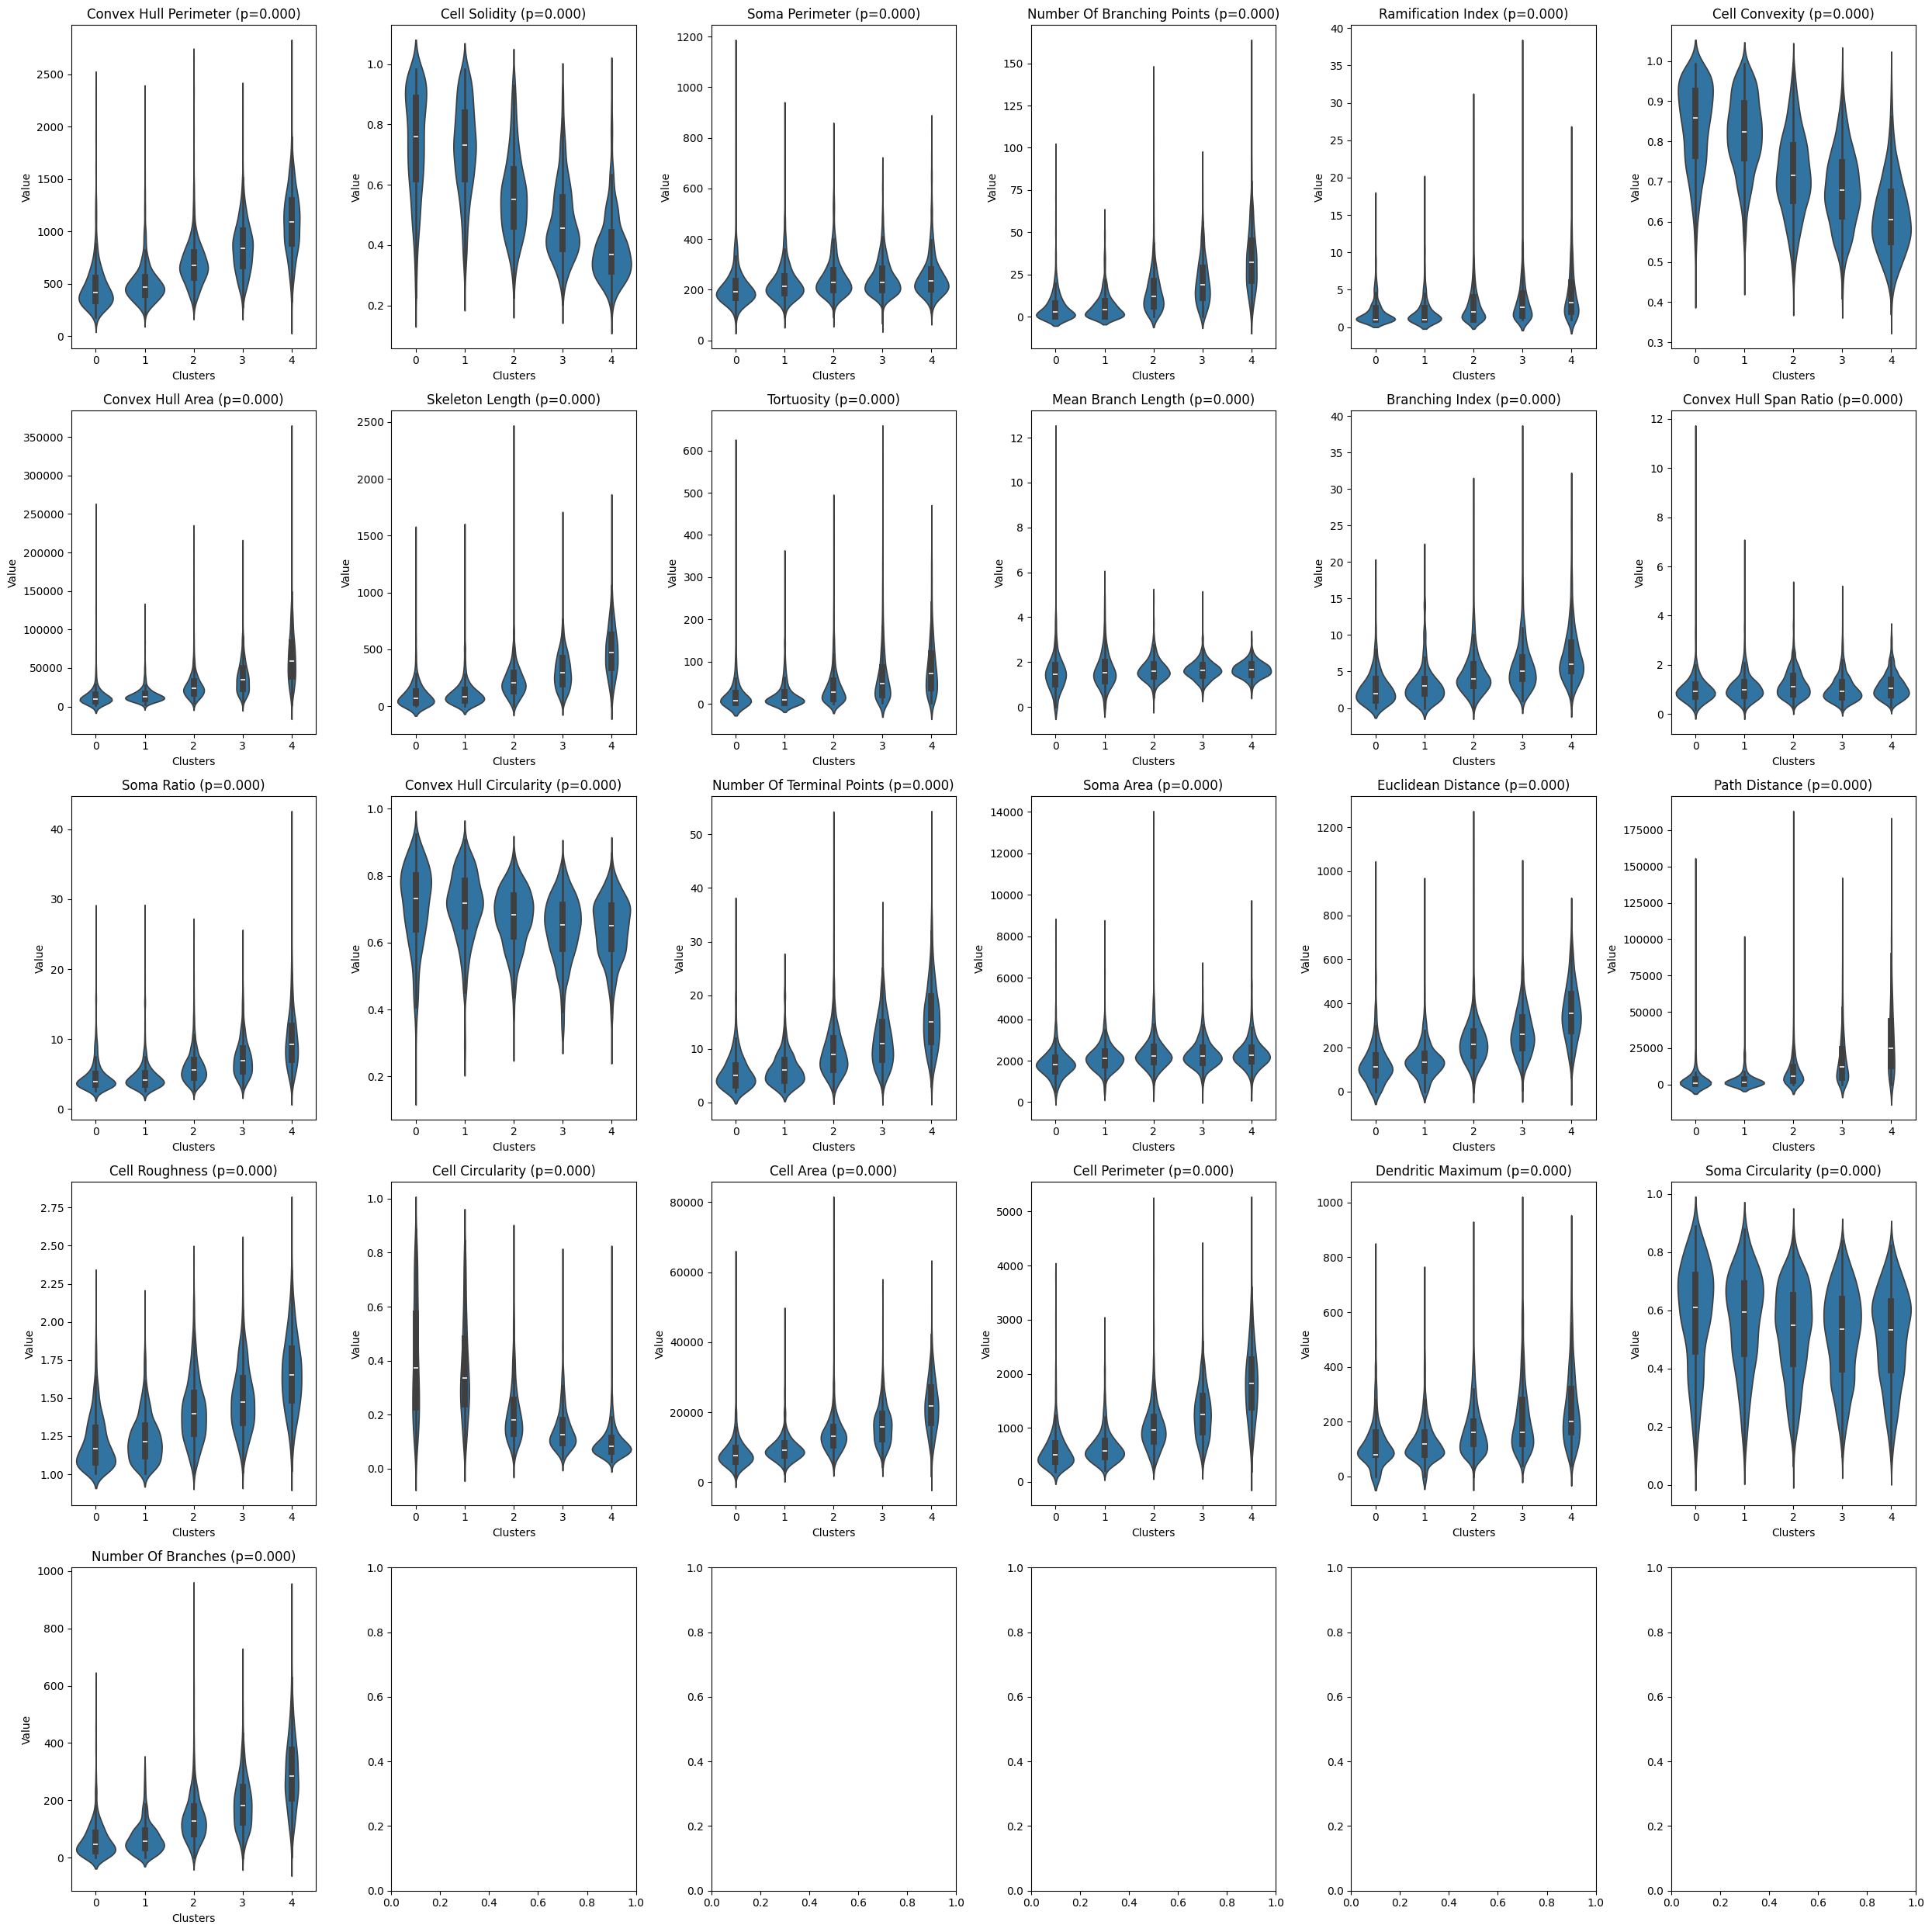

                            F-statistic        p-value  corrected p-value
Convex Hull Perimeter        733.677154   0.000000e+00       0.000000e+00
Cell Solidity                817.354950   0.000000e+00       0.000000e+00
Soma Perimeter                32.321479   1.349264e-26       1.533254e-26
Number of Branching Points   526.912812   0.000000e+00       0.000000e+00
Ramification Index            91.674620   5.856175e-75       7.705494e-75
Cell Convexity               630.041884   0.000000e+00       0.000000e+00
Convex Hull Area             595.891324   0.000000e+00       0.000000e+00
Skeleton Length              618.957645   0.000000e+00       0.000000e+00
Tortuosity                   189.145207  5.717440e-150      8.408000e-150
Mean Branch Length             5.456432   2.219407e-04       2.219407e-04
Branching Index              238.585257  6.391429e-186      9.986608e-186
Convex Hull Span Ratio        20.353415   1.239389e-16       1.291031e-16
Soma Ratio                   402.28418

In [12]:
new_ad.obs['ordered morph'] = new_ad.obs['ordered_morph'].astype(str).sort_values()

fig, axes = plt.subplots(5, 6, figsize=(25, 25))  # Adjust grid size as needed
anova_results = {}  # Dictionary to store ANOVA results for each feature

# Collect all p-values to adjust them after the loop
all_p_values = []

for i, feature in enumerate(features):
    row = i // 6
    col = i % 6
    y_feature = feature  # The y-axis feature to plot

    # Sorting 'ordered morph' for each plot
    sns.violinplot(x='ordered morph', y=y_feature, data=new_ad.obs, ax=axes[row, col], inner='box', order=sorted(new_ad.obs['ordered morph'].unique()))
    
    # Perform ANOVA
    groups = [new_ad.obs[new_ad.obs['ordered morph'] == cluster][y_feature].dropna() for cluster in sorted(new_ad.obs['ordered morph'].unique())]
    f_stat, p_value = stats.f_oneway(*groups)  # ANOVA calculation
    
    # Store the initial result and save the p-value for multiple testing correction
    anova_results[feature] = {'F-statistic': f_stat, 'p-value': p_value}
    all_p_values.append(p_value)

    # Set basic title and labels before adding corrected p-value
    axes[row, col].set_title(feature.replace('_', ' ').title())
    axes[row, col].set_xlabel('Clusters')
    axes[row, col].set_ylabel('Value')

    if i == 24:  # Stop after the 25th feature
        break

# Apply multiple testing correction to all p-values
_, corrected_p_values, _, _ = multipletests(all_p_values, method='fdr_bh')  # Benjamini-Hochberg (FDR) correction

# Update anova_results with corrected p-values and update plot titles
for i, feature in enumerate(features):
    anova_results[feature]['corrected p-value'] = corrected_p_values[i]

    # Update plot titles to include corrected p-value
    row = i // 6
    col = i % 6
    if i < 25:  # To ensure we don't exceed subplot limits
        axes[row, col].set_title(f"{feature.replace('_', ' ').title()} (p={corrected_p_values[i]:.3f})")
    if i == 24:
        break

# Save the plot
plt.tight_layout()
plt.savefig('figures/morphology_by_cluster_sorted_clusters.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Optionally, display or save the ANOVA results
anova_df = pd.DataFrame(anova_results).T  # Convert to DataFrame for easy viewing
print(anova_df)

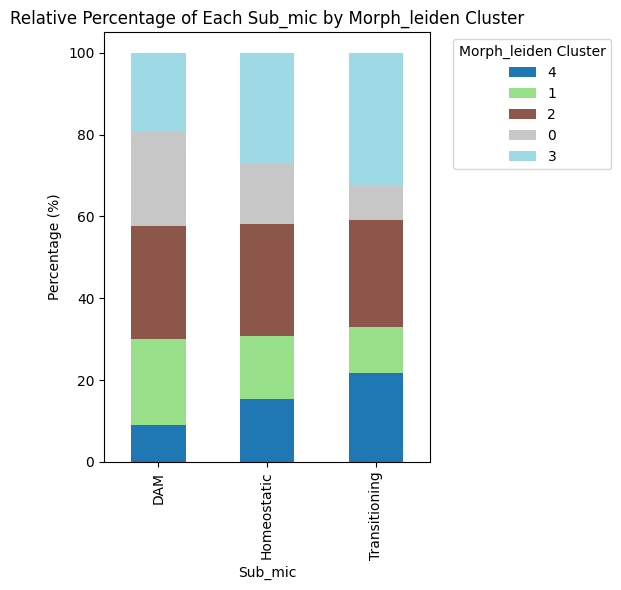

In [13]:
def plot_stacked_bar(adata, group_col='sub_mic', cluster_col='morph_leiden',output_pdf=None):
    """
    Create a stacked bar plot showing the relative percentage of each sub_mic group 
    corresponding to each morph_leiden cluster.

    Parameters:
    - adata: AnnData object with obs columns for 'sub_mic' and 'morph_leiden'.
    - group_col: Column name in obs representing the group (default: 'sub_mic').
    - cluster_col: Column name in obs representing the clusters (default: 'morph_leiden').
    
    Returns:
    - Displays a stacked bar plot.
    """
    # Create a DataFrame from obs with relevant columns
    df = adata.obs[[group_col, cluster_col]]
    
    # Calculate the counts of morph_leiden clusters within each sub_mic
    count_df = pd.crosstab(df[group_col], df[cluster_col])
    
    # Convert counts to percentages
    percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
    
    # Plot the stacked bar plot
    ax = percentage_df.plot(kind='bar', stacked=True, figsize=(6, 6), colormap='tab20')
    
    # Add labels and title
    plt.title('Relative Percentage of Each Sub_mic by Morph_leiden Cluster')
    plt.xlabel('Sub_mic')
    plt.ylabel('Percentage (%)')
    plt.legend(title='Morph_leiden Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Display the plot
    plt.tight_layout()
    if output_pdf:
        plt.savefig(output_pdf, format='pdf', bbox_inches='tight')
    plt.show()

# Example usage:
plot_stacked_bar(new_ad, group_col='sub_mic', cluster_col='ordered_morph',output_pdf='figures/stacked_bar_morphology_in_transcripts.pdf')

# DEGs

In [14]:
def perform_deg(adata, groupby, group1, group2):
    adata.obs['comparison'] = adata.obs[groupby].astype(str).apply(lambda x: group1 if x == group1 else (group2 if x == group2 else None))
    adata_sub = adata[adata.obs['comparison'].notnull(), :].copy()
    adata_sub.obs['comparison'] = adata_sub.obs['comparison'].astype('category')
    adata_sub.obs['comparison'].cat.reorder_categories([group1, group2])
    sc.tl.rank_genes_groups(adata_sub, 'comparison', reference=group1, method='wilcoxon',use_raw=False)
    result = adata_sub.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    deg_df = pd.DataFrame({
        'names': result['names'][group2],
        'logfoldchanges': result['logfoldchanges'][group2],
        'pvals': result['pvals'][group2],
        'pvals_adj': result['pvals_adj'][group2]
    })
    return deg_df

def perform_deg_pop(adata, groupby, group1, group2, min_expr_fraction=0.3):
    # Create comparison column
    adata.obs['comparison'] = adata.obs[groupby].astype(str).apply(lambda x: group1 if x == group1 else (group2 if x == group2 else None))
    adata_sub = adata[adata.obs['comparison'].notnull(), :].copy()
    adata_sub.obs['comparison'] = adata_sub.obs['comparison'].astype('category')
    adata_sub.obs['comparison'].cat.reorder_categories([group1, group2])
    
    # Calculate fraction of cells expressing each gene within group1 and group2
    group1_cells = adata_sub[adata_sub.obs['comparison'] == group1]
    group2_cells = adata_sub[adata_sub.obs['comparison'] == group2]
    
    expr_fraction_group1 = (group1_cells.X > 0).sum(axis=0) / group1_cells.shape[0]
    expr_fraction_group2 = (group2_cells.X > 0).sum(axis=0) / group2_cells.shape[0]
    
    # Find genes expressed in at least 30% of cells in either group
    valid_genes = (expr_fraction_group1 >= min_expr_fraction) | (expr_fraction_group2 >= min_expr_fraction)
    
    # Perform DEG analysis
    sc.tl.rank_genes_groups(adata_sub, 'comparison', reference=group1, method='wilcoxon')
    result = adata_sub.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    
    # Create DEG DataFrame
    deg_df = pd.DataFrame({
        'names': result['names'][group2],
        'logfoldchanges': result['logfoldchanges'][group2],
        'pvals': result['pvals'][group2],
        'pvals_adj': result['pvals_adj'][group2]
    })
    
    # Filter by valid genes
    deg_df = deg_df[deg_df['names'].isin(adata.var_names[valid_genes])]
    
    return deg_df



def perform_deg_stratified(adata, groupby, group1, group2, confounder):
    # Initialize a DataFrame to store results
    combined_deg_df = pd.DataFrame()

    # Get unique values of the confounder (e.g., Age)
    confounder_levels = adata.obs[confounder].unique()

    for level in confounder_levels:
        # Subset data to the current level of the confounder
        adata_sub = adata[adata.obs[confounder] == level, :].copy()
        
        # Perform the differential expression analysis as before
        adata_sub.obs['comparison'] = adata_sub.obs[groupby].astype(str).apply(
            lambda x: group1 if x == group1 else (group2 if x == group2 else None))
        adata_sub = adata_sub[adata_sub.obs['comparison'].notnull(), :].copy()
        adata_sub.obs['comparison'] = adata_sub.obs['comparison'].astype('category')
        adata_sub.obs['comparison'].cat.reorder_categories([group1, group2])

        sc.tl.rank_genes_groups(adata_sub, 'comparison', reference=group1, method='wilcoxon')
        result = adata_sub.uns['rank_genes_groups']

        # Extract DEGs for the current level of the confounder
        deg_df = pd.DataFrame({
            'names': result['names'][group2],
            'logfoldchanges': result['logfoldchanges'][group2],
            'pvals': result['pvals'][group2],
            'pvals_adj': result['pvals_adj'][group2],
            'confounder_level': level
        })

        # Combine the results
        combined_deg_df = pd.concat([combined_deg_df, deg_df], ignore_index=True)

    return combined_deg_df

In [15]:
new_ad.X = new_ad.layers['total_counts'].copy()
sc.pp.normalize_total(new_ad, target_sum=1e4)
sc.pp.log1p(new_ad)

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [16]:
morphology = perform_deg(new_ad, 'ordered_morph', '4', '0')
transcriptome = perform_deg(new_ad, 'sub_mic', 'Homeostatic', 'DAM')

morph = set(morphology[(morphology.pvals_adj < 0.05)]['names'])
gene = set(transcriptome[(transcriptome.pvals_adj < 0.05)]['names'])

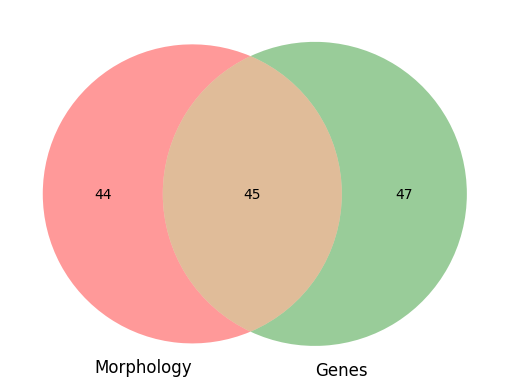

In [17]:
venn = venn2([morph, gene], ('Morphology', 'Genes'))
plt.savefig('figures/venn_diagram.pdf', format='pdf', bbox_inches='tight')
plt.show()

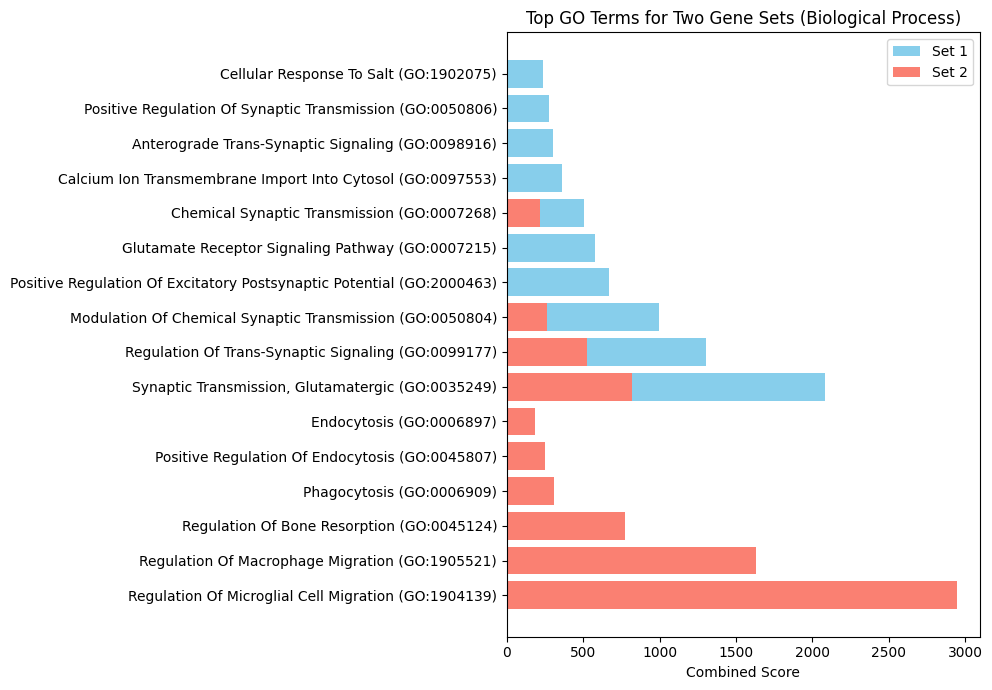

In [18]:
shared_names_1 = morph  # Example: set 1 (e.g., morphology-related genes)
shared_names_2 = gene  # Example: set 2 (e.g., upregulated genes)

# Convert to a list
shared_genes_1 = list(shared_names_1)
shared_genes_2 = list(shared_names_2)

# Perform GO analysis using gseapy for biological processes, cellular components, and molecular functions
gene_sets = ['GO_Biological_Process_2023']

# Function to perform GO analysis and return the results
def perform_go_analysis(genes, gene_sets, organism):
    results = {}
    for gene_set in gene_sets:
        go_results = gp.enrichr(gene_list=genes,
                                gene_sets=[gene_set],
                                organism=organism,
                                outdir=None)
        results[gene_set] = go_results.results[['Term', 'Combined Score']].head(10)  # Get top 5 results
    return results

# GO analysis for both gene sets
go_results_1 = perform_go_analysis(shared_genes_1, gene_sets, 'Mouse')
go_results_2 = perform_go_analysis(shared_genes_2, gene_sets, 'Mouse')

# Combine results into a single dataframe for easier plotting
def perform_go_analysis(genes, gene_sets, organism):
    results = {}
    for gene_set in gene_sets:
        go_results = gp.enrichr(gene_list=genes,
                                gene_sets=[gene_set],
                                organism=organism,
                                outdir=None)
        # Filter based on adjusted p-value < 0.01 and keep relevant columns
        filtered_results = go_results.results[go_results.results['Adjusted P-value'] < 0.01]
        results[gene_set] = filtered_results[['Term', 'Combined Score', 'Adjusted P-value']].head(10)  # Get top results
    return results

# GO analysis for both gene sets
go_results_1 = perform_go_analysis(shared_genes_1, gene_sets, 'Mouse')
go_results_2 = perform_go_analysis(shared_genes_2, gene_sets, 'Mouse')

# Combine results into a single dataframe for easier plotting
def merge_go_results(go_res_1, go_res_2, gene_set):
    df_1 = go_res_1[gene_set].copy()
    df_2 = go_res_2[gene_set].copy()
    df_1['Set'] = 'Set 1'  # Label for first gene set
    df_2['Set'] = 'Set 2'  # Label for second gene set
    combined = pd.concat([df_1, df_2])
    return combined

# Merge the GO results for plotting
combined_go_results = merge_go_results(go_results_1, go_results_2, 'GO_Biological_Process_2023')

# Sort by the maximum Combined Score to ensure correct order
combined_go_results['Max Combined Score'] = combined_go_results.groupby('Term')['Combined Score'].transform('max')
combined_go_results = combined_go_results.sort_values(by='Max Combined Score', ascending=True).drop(columns='Max Combined Score')

# Plotting the results
fig, ax = plt.subplots(figsize=(10, 7))

# Create bar plot colored by Set
colors = {'Set 1': 'skyblue', 'Set 2': 'salmon'}
for label, df_subset in combined_go_results.groupby('Set'):
    ax.barh(df_subset['Term'], df_subset['Combined Score'], label=label, color=colors[label])

# Customize the plot
ax.set_xlabel('Combined Score')
ax.set_title('Top GO Terms for Two Gene Sets (Biological Process)')
ax.invert_yaxis()  # Display the highest values on top
ax.legend()

# Save and show the plot
plt.tight_layout()
plt.savefig('figures/morphology_genes_GO_comparison_filtered.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [19]:
new_ad.X = new_ad.layers['total_counts'].copy()
sc.pp.normalize_total(new_ad,target_sum=1e4)
sc.pp.log1p(new_ad)
sc.tl.score_genes(new_ad,gene_list=['Slc1a2','Gria2','Dlgap2','Dlg2','Dagla'],score_name='glut')

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [20]:
DAM_cells = new_ad[(new_ad.obs.sub_mic == 'DAM') & (new_ad.obs.ordered_morph.isin(['0','4']))]
homeostatic_cells = new_ad[(new_ad.obs.sub_mic == 'Homeostatic') & (new_ad.obs.ordered_morph.isin(['0','4']))]

DAM_morph = perform_deg(DAM_cells, 'ordered_morph', '4', '0')
homeo_morph = perform_deg(homeostatic_cells, 'ordered_morph', '4', '0')

/tmp/ipykernel_1434273/1104488575.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['comparison'] = adata.obs[groupby].astype(str).apply(lambda x: group1 if x == group1 else (group2 if x == group2 else None))
/tmp/ipykernel_1434273/1104488575.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['comparison'] = adata.obs[groupby].astype(str).apply(lambda x: group1 if x == group1 else (group2 if x == group2 else None))


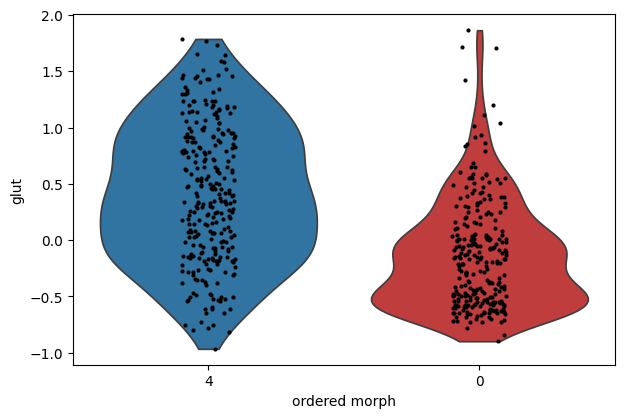

In [21]:
sc.pl.violin(homeostatic_cells,keys='glut',groupby='ordered_morph',use_raw=False,size=3,save='active_glut.pdf')